## Pair Programming - Regresión lineal 1

### Intro Machine Learning

---

### 1. Importamos las librerías necesarias.

In [202]:
# Tratamiento de los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')


### 2. Abrimos el archivo con el que vamos a trabajar.

In [203]:
df = pd.read_csv('../archivos/Metro_Interstate_Traffic_Volume.csv.gz')

In [204]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


La variable respuesta será 'traffic_volume' y las predictoras depende de las conclusiones que saquemos de la exploración y análisis de los datos pero habrá alguna de temperatura y otras relacionadas con el día y la hora.

### 3. EDA 

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [206]:
print(f"Número de filas ---> {df.shape[0]}\nNúmero de columnas ---> {df.shape[1]}")

Número de filas ---> 48204
Número de columnas ---> 9


In [207]:
df.duplicated().sum() #vemos que hay 17 filas duplicadas, los eliminarlos

17

In [208]:
df.drop_duplicates(inplace=True)

In [209]:
df.shape

(48187, 9)

In [210]:
df.describe().T #variables numéricas

,count,mean,std,min,25%,50%,75%,max
temp,48187.0,281.204995,13.338738,0.0,272.16,282.45,291.806,310.07
rain_1h,48187.0,0.334382,44.797033,0.0,0.00,0.00,0.000,9831.30
snow_1h,48187.0,0.000222,0.008169,0.0,0.00,0.00,0.000,0.51
clouds_all,48187.0,49.365451,39.015213,0.0,1.00,64.00,90.000,100.00
traffic_volume,48187.0,3259.618134,1986.954465,0.0,1192.50,3379.00,4933.000,7280.00


In [211]:
df.describe(include='object').T #variables categóricas

,count,unique,top,freq
holiday,48187,12,None,48126
weather_main,48187,11,Clouds,15158
weather_description,48187,38,sky is clear,11659
date_time,48187,40575,2013-04-18 22:00:00,6


In [212]:
df.isnull().sum() #no hay valores nulos

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [213]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

### 4. Limpieza.

Procedemos a una limpieza más exaustiva teniendo en cuenta nuestra nueva hipótesis, que se va a centrar en cual de las variables (día y hora) influye más en el volumen de personas en el metro.

In [214]:
df.head(1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545


### 4.1. Recategorizamos la columna "holiday" como Si o No.

In [215]:
def festivos(col):
    if col == "None":
        return 'no'
    else:
        return 'si'

In [216]:
df["holiday_cat"]= df["holiday"].apply(festivos)

In [217]:
df["holiday_cat"].value_counts()

no    48126
si       61
Name: holiday_cat, dtype: int64

In [218]:
#Borramos la columna holiday al tener la información mejor categorizada en otra columna
df.drop('holiday', axis=1, inplace=True)

### 4.2. Recategorizamos la columna "date_time" para crear una solo con la fecha y otra con la hora. 

In [219]:
df[["date","time"]]= df["date_time"].str.split(expand=True)


In [220]:
#Borramos la columna date_time al tener la información separada en dos columnas
df.drop('date_time', axis=1, inplace=True)

### 4.3. Creamos una nueva columna "weekday" a través de la columna "fecha" con los días de la semana.

In [221]:
def dia_semana(col):
    return col.isoweekday()

In [222]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [223]:
df["weekday"]= df["date"].apply(dia_semana)


In [224]:
mapa_dias = {1: 'lunes', 2: 'martes', 3: 'miercoles', 4: 'jueves', 5: 'viernes', 6: 'sabado', 7: 'domingo'}
df['weekday']= df['weekday'].map(mapa_dias)

📍Decidimos categorizarlo por el nombre de los días para poder analizar el peso de cada día de cara al Anova, aunque en el encoding lo podremos separar como entre semana y fin de semana.

In [225]:
df.head(2)

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,holiday_cat,date,time,weekday
0,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,no,2012-10-02,09:00:00,martes
1,289.36,0.0,0.0,75,Clouds,broken clouds,4516,no,2012-10-02,10:00:00,martes


### 4.4. Recategorizamos la columna "season"

In [226]:
df['date'] = df["date"].astype("str")

In [227]:
df["season"] = df["date"].str.split("-")

def sacar_estacion(col):
   
    if (col[1] == "09" and col[2] >= "23" ) | (col[1] == "10") | (col[1] == "11") | (col[1] == "12" and col[2] <= "20" ):
        return "Autumn"
    elif (col[1] == "12" and col[2] >= "21" ) | (col[1] == "01") | (col[1] == "02") | (col[1] == "03" and col[2] <= "20" ):
        return "Winter"
    elif (col[1] == "03" and col[2] >= "21" ) | (col[1] == "04" ) | (col[1] == "05") | (col[1] == "06" and col[2] <= "20" ):
        return "spring"
    elif (col[1] == "06" and col[2] >= "21" ) | (col[1] == "07" ) | (col[1] == "08") | (col[1] == "09" and col[2] <= "22" ):
        return "Summer"

In [228]:
df["season"][0]

['2012', '10', '02']

In [229]:
df["season"] = df["season"].apply(sacar_estacion)

In [230]:
df.sample()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,holiday_cat,date,time,weekday,season
21304,269.01,0.0,0.0,75,Haze,haze,4047,no,2016-02-15,10:00:00,lunes,Winter


In [231]:
df.drop("date", axis=1, inplace=True)

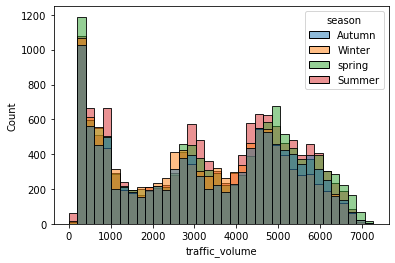

In [232]:
sns.histplot(x="traffic_volume", hue="season", data= df);

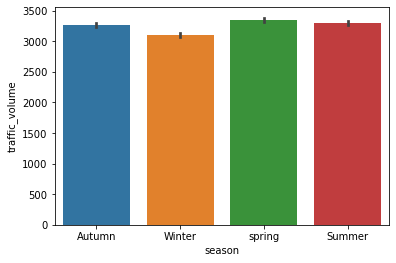

In [233]:
sns.barplot(x="season", y= "traffic_volume", data=df);

### 4.5 Categorizamos la columna de "time" 

In [234]:
df["time"].unique()

array(['09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00',
       '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00',
       '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00',
       '00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
       '05:00:00', '06:00:00', '08:00:00', '07:00:00'], dtype=object)

Dividimos entre:

- "morning" de 06 a 13
- "midday" de 14 a 17
- "evening" de 18 a 22
- "night" de 23 a 05

In [235]:
def horas(col):
    if col >= '06:00:00' and col  <= '13:00:00':
        return "morning"
    elif col >= '14:00:00' and col  <= '17:00:00':
        return "midday"
    elif col >= '18:00:00' and col  <= '22:00:00':
        return "evening"
    else:
        return "night"

In [236]:
df["cat_time"] = df["time"].apply(horas)

In [237]:
df.drop("time", axis=1, inplace=True)

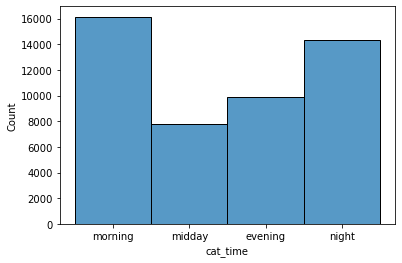

In [238]:
sns.histplot(x="cat_time",  data= df);

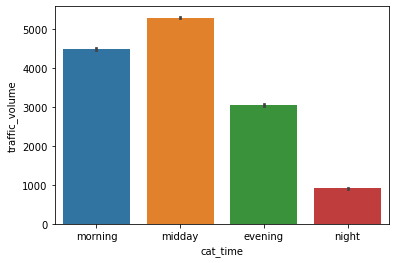

In [239]:
sns.barplot(x="cat_time", y= "traffic_volume", data=df);

### 4.6. Transformamos la columna "temp" de grados kelvin a celsius.

Analizamos la columna y vemos que hay once registros de 0.0 kelvin. Estudiamos las temperaturas de ese día en diferentes horas e intuimos que son errores de registro, ya que el resto de temperaturas antes y después de los registros 0.0 rondan los 255 grados.

Decidimos no borralos para mantener el resto de datos y reemplazarlo por la misma temperatura de la hora de antes y la hora de después. 

In [240]:
def celsius(col):
    if col == 0:
        return -17
    else:
        return col -273.15

In [241]:
df['temp_c'] = df['temp'].apply(celsius)

### 4.7. Definimos las columnas con las que seguimos haciendo el EDA, normalización y demás procesos.

In [242]:
df_2 = df[['season', 'weekday', 'cat_time', 'holiday_cat', 'temp_c', 'snow_1h', 'traffic_volume']]
df_2.head()

,season,weekday,cat_time,holiday_cat,temp_c,snow_1h,traffic_volume
0,Autumn,martes,morning,no,15.13,0.0,5545
1,Autumn,martes,morning,no,16.21,0.0,4516
2,Autumn,martes,morning,no,16.43,0.0,4767
3,Autumn,martes,morning,no,16.98,0.0,5026
4,Autumn,martes,morning,no,17.99,0.0,4918


### 5. Tratamiento de outliers.

In [243]:
numericas= df_2.select_dtypes(include= np.number).columns.tolist()
print(numericas)

['temp_c', 'snow_1h', 'traffic_volume']


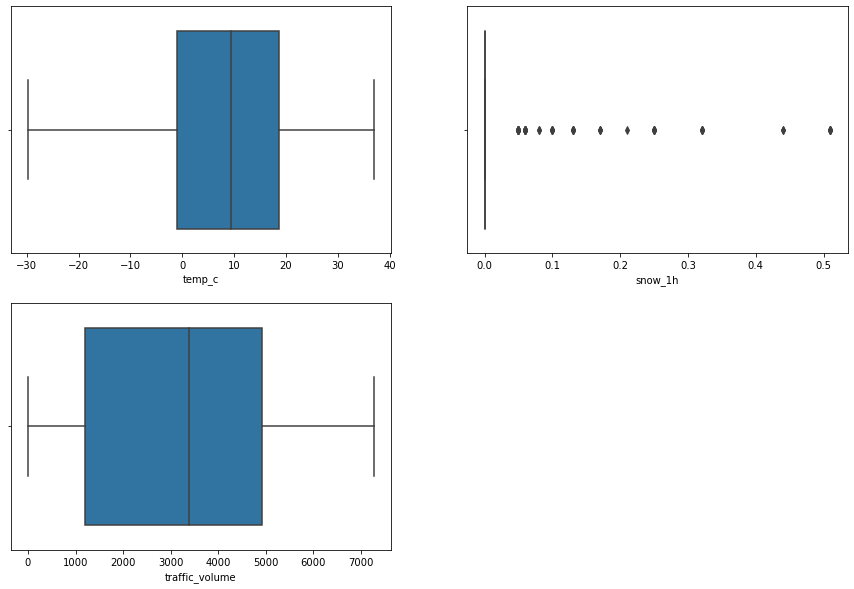

In [244]:
# Gráficas para ver los outliers de cada variable numérica

fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flat

for i,col in enumerate(numericas):
  
    sns.boxplot(x= col, data=df_2, ax=axes[i])
    
fig.delaxes(axes[-1])

📍Dejamos los outliers de la columna "snow_1h" porque son registros de meteorología que queremos ver si influyen (normalmente no nieva, pero los outliers son los registros de los días que si)

### 6. Gráficas con la distribución y relación de las variables.

### 6.1. Gráfica para ver como está distribuida la variable respuesta.

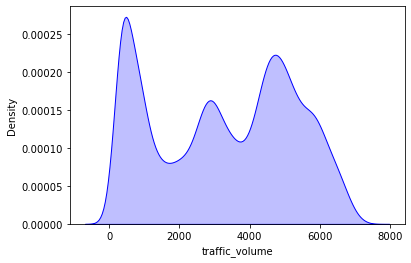

In [245]:
sns.distplot(
    df_2["traffic_volume"], 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

In [246]:
df_2[df_2['traffic_volume'] < 1]
#Filtramos la variable respuesta para encontrar los registros negativos pero no aparecen.. 

,season,weekday,cat_time,holiday_cat,temp_c,snow_1h,traffic_volume
25186,Summer,sabado,evening,no,23.53,0.0,0
25191,Summer,sabado,night,no,22.75,0.0,0


### 6.2. Gráficas de distribución para cada variable numérica.

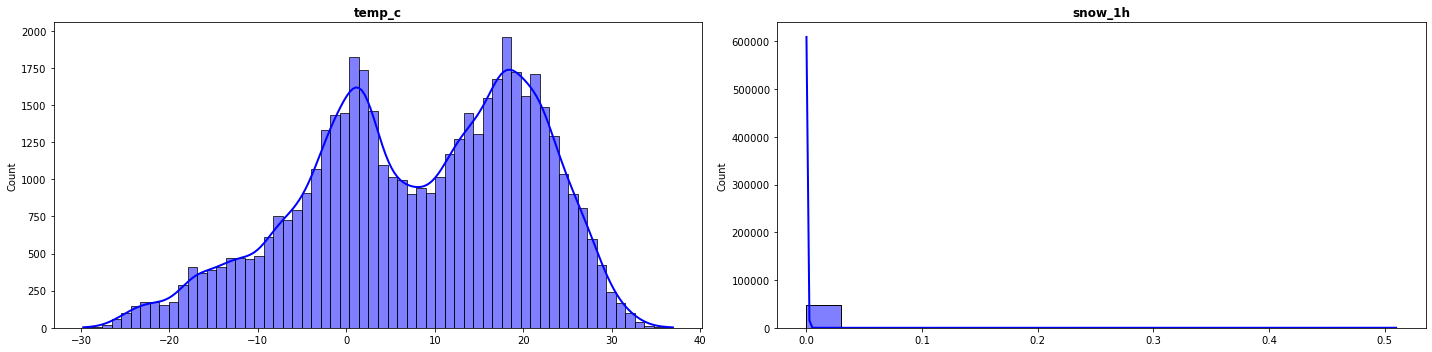

In [247]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

axes = axes.flat

numericas= numericas[:-1]

for i, colum in enumerate(numericas): 
    sns.histplot(
        data = df_2,
        x = colum,
        kde = True, 
        color = "blue", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
   
fig.tight_layout();


### 6.3. Gráficas de relación entre variables predictoras y la variable a predecir.

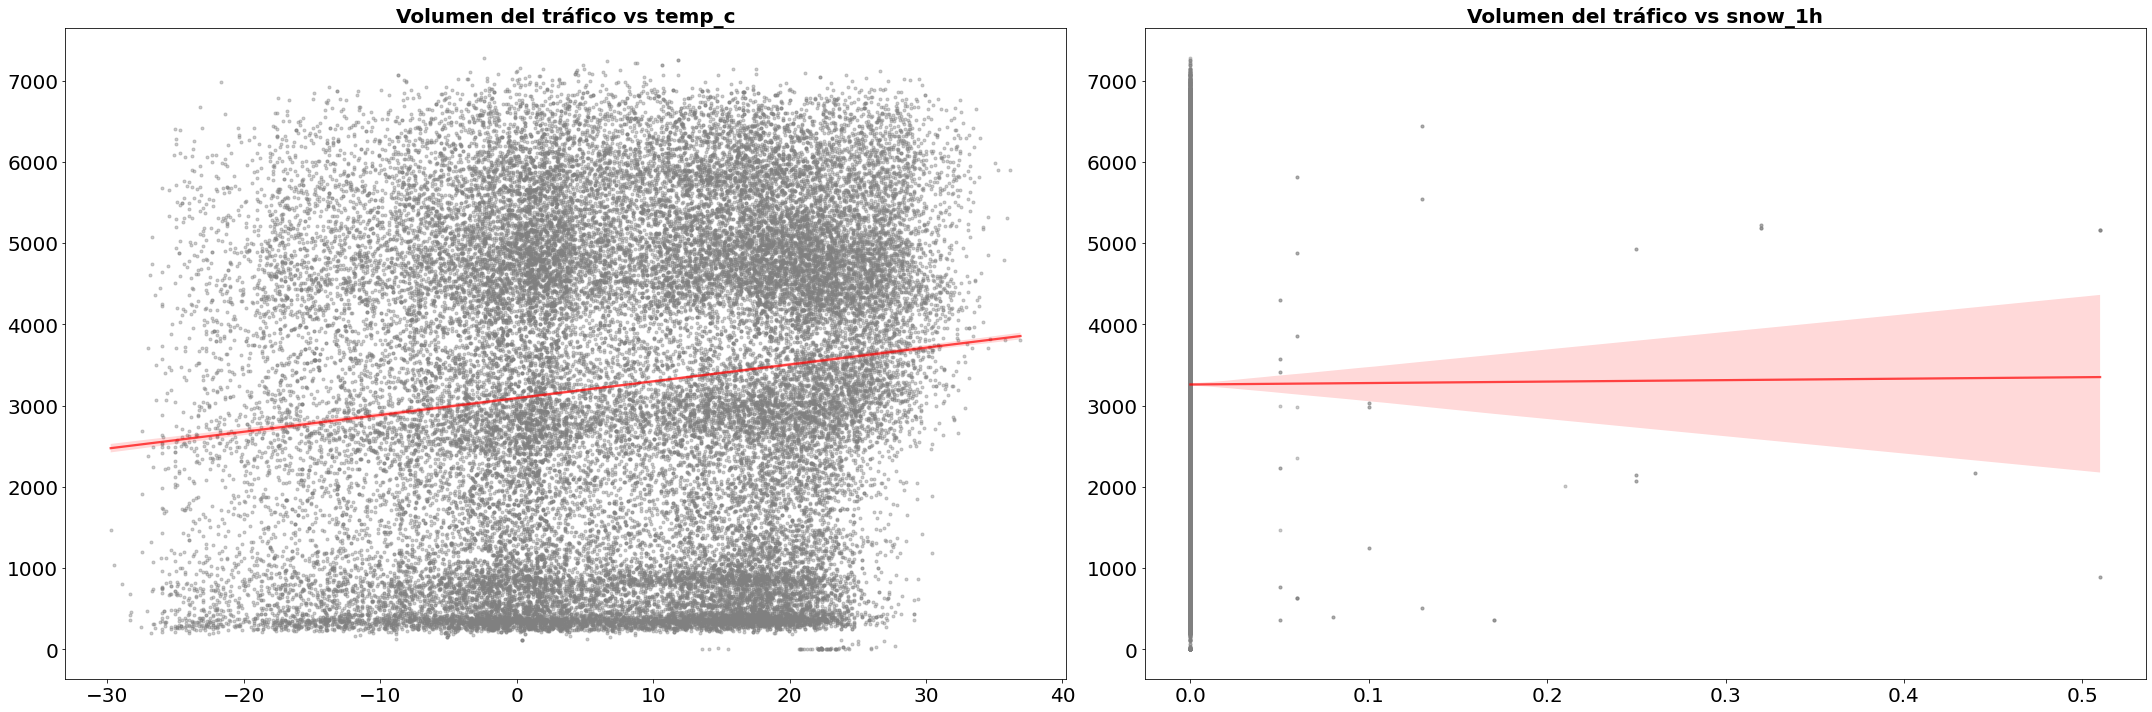

In [248]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))

axes = axes.flat

#numericas= numericas[:-1]

for i, colum in enumerate(numericas):
    sns.regplot(
        x = df_2[colum], 
        y = df_2["traffic_volume"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Volumen del tráfico vs {colum}", fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
 
fig.tight_layout();

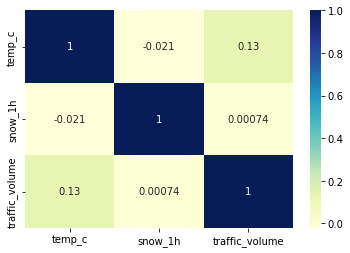

In [249]:
sns.heatmap(df_2.corr(), 
           cmap = "YlGnBu", 
           annot = True);

### 7. Guardamos el archivo con los cambios

In [251]:
df_2.to_csv("../archivos/metro_A.csv")